# Introduction

The development and deployment of machine learning systems in real-world scenarios produces a cautelosus attention of not just of the good performance in most of the time, but also in a robust manner.

Recently, robustness is commond used for adversarial robustness, which means develop classifiers robustly in testing time to perturbations on their inputs in order to fool a model. 

This notion of robustness is taking a big interest in the academia and industry for tackling the deficiencies in advanced machine learning systems, in particular deep learning.

## Creating a model

We are going to use a ResNet50 model and PyTorch to make a classification model.

Generally, the strategy of image classification in PyTorhc is to first transform the image to approximatelet zero-mean and unit variance. However, we want to make perturbations in the original (unnormalized) image space.

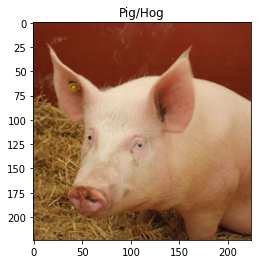

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("ml-adversarial-robustness/data/pig.jpg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])

pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.title("Pig/Hog")
plt.show()

Next, we load a pre-trained ResNet50 model and apply it to the image

In [6]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

Now we load the list of ImageNet classes and compare our prediction with the maximum value of this vector

In [7]:
import json
with open("ml-adversarial-robustness/data/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
    
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


Create a prediction from model

In [8]:
pred = model(norm(pig_tensor))

In [9]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  hog
Predicted probability: 0.9961252808570862


In [10]:
pred.shape

torch.Size([1, 1000])

Pred is a logit vector of the 1000 classes of imagenet. We could convert this logit vector to a probability vector ussing softmax.

**A logit $L$ of probability $p$ is defined as**

$$
L = ln \frac{p}{1-p}
$$

where $\frac{p}{1-p}$ is called *odds*, thus the natural logithm of the odds is known as *log-odds* or *logit*


**So, the inverse function is**

$$
p= \frac{1}{1+e^{-L}}
$$

Hence, probabilities ranges from zero to one, i.e., $p \in [0,1]$, whereas logits can be any real number $\mathbb{R}$ from minus infinity to infinity, i.e., $L \in (-\infty, \infty)$

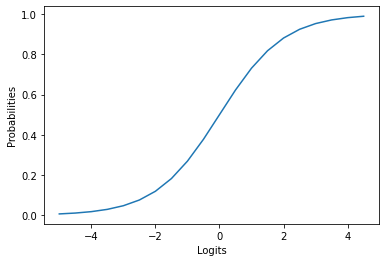

In [11]:
import numpy as np

logits = np.arange(-5, 5, .5)
probs = 1 / (1 + np.exp(-logits))

plt.plot(logits, probs)
plt.xlabel("Logits")
plt.ylabel("Probabilities")
plt.show()

In [31]:
pred.max(dim=1)[1].item()

341

The predicition is good!

## Basic Notation

Our model or hypothesis functions is defined as:

$$
h_\theta: X \rightarrow \mathbb{R}^k
$$

Which is a mapping function from our inputs (images) to a $k$-dimensional vector, where $k$ is the number of classes being predicted.

Note the output corresponds to a logit space, so these real-values can be positive or negative. Also, $\theta$ stands for all the parameters learned by the model, these are what typically is optimized when training a neural network. Hence $h_\theta$ is our model object  

### Loss Function

We define our loss function $\ell: \mathbb{R}^k \times \mathbb{Z}_+ \rightarrow \mathbb{R}_+$ as a mapping from the model predictions (logits) $\mathbb{R}^k$ and true labels (index of true class) $\mathbb{Z}_+$ to a non-negative number $\mathbb{R}_+$

Thus, $$ \ell(h_\theta(x), y) $$
is the loss for $x \in X$ the input and $y \in \mathbb{Z}$ the true class that a classifier achieves when prediction $x$ assuming the true class is $y$.

The most common loss function in deep learning is the cross-entropy loss (aka softmax loss)

$$
\ell(h_\theta(x), y) = log \left( \sum_{j=^1}^{k} exp(h_\theta(x)_j) \right) - h_\theta(x)_y
$$

where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$

#### Notion of Softmax loss

It comes from a typical softmax activation. We define the softmax operator as $\sigma: \mathbb{R}^k \rightarrow \mathbb{R}^k$ applied to a vector $z$

$$
\sigma(z)_i = \frac{exp(z_i)}{\sum_{j=1}^{k}exp(z_j)}
$$




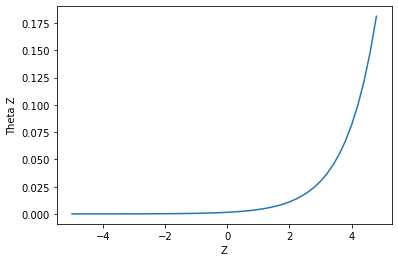

In [12]:
z = np.arange(-5, 5, .2)
theta_z = np.exp(z) / np.sum(np.exp(z))

plt.plot(z, theta_z)
plt.xlabel("Z")
plt.ylabel("Theta Z")
plt.show()

In [87]:
np.exp(z).sum()

670.3006881613314

Then, softmax returns a probability distribution. The goal of a NN is to maximize the probability of the true class label.
Since probabilities themselves get vanishingly small, it is common to maximize the *log* pf the probability of the true class label

$$
\log \sigma(h_\theta(x))_y = \log \left(\frac{exp(h_\theta(x)_y)}{\sum_{j=1}^{k}exp(h_\theta(x)_j)} \right) = h_\theta(x)_y - \log \left(  \sum_{j=1}^{k}exp(h_\theta(x)_j) \right)
$$

In order to **minimize** the loss (rather than maximizing the probability), it is used the negation of this quantity as loss function.

In PyTorch can be done as:

In [13]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


We can conclude that **0.0038** is quite small. We can take the exponential of it to get the probability of the prediction that classifier believes is a pig(hog
$$
exp(-0.0039) \approx 0.996
$$

## Creating adversarial examples

The innetion of an aversarial example is to fool the classifier to believe is something else. A common approach to train a model is to optimize parameters $\theta$ in order to minimize the average loss over the a training set ${x_i \in X, y_i \in \mathbb{Z}}, i = 1, ...m$

Thus, we can write this as an optimization problem

$$
\underset{\theta}{\text{minimize }} \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x_i), y_i)
$$

Next, we solve it by Stochastic Gradient Descent (SGD), for some minibatch $\mathcal{B} \subseteq \{1, ..., m\}$, by computing the gradient of the loss with respect to parameters $\theta$, and updating $\theta$ to its negative direction.

$$
\theta:= \theta - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \nabla_\theta \ell(h_\theta(x_i), y_i)
$$

where $\alpha$ is the learning rate or step size.

**The gradient computes how small is the adjustment to each parameters $\theta$ that will affect to the loss function.**
For Deep Neural Networks, the gradient is computed via backpropagation.

To create an adversarial example we are going to adjust the image $x$ to *maximize* the loss. The optimization problem is as following:

$$
\underset{\hat{x}}{\text{maximize }} \ell(h_\theta(\hat{x}), y)
$$

Here, $\hat{x}$ es the adversarial example that is trying to maximize the loss. This is not a trivial task, we can not change the image completly so that a classifier is being fool. The adversarial example must ensure that $\hat{x}$ is **close** to the original input $x$. This can be done by optimizing over the **perturbation** to $x$, which by convention is denoted as $\delta$

$$
\underset{\delta \in \Delta}{\text{maximize }} \ell(h_\theta(x + \delta), y)
$$

where $\Delta$ represents an allowable set of perturbations.

> Characterizing the **“correct”** set of allowable perturbations is actually quite difficult: in theory, we would like $\Delta$ to capture anything that humans visually feel to be the “same” as the original input x.

$\Delta$ can include adding slight amounts of n oise, rotating, translationg, scaling or transformations on the image locations.

It cannot be possible to give a mathematicall rigorous definitions of the all set of perturbations allowe. We consider a subset of possible space of allowed perturbations, such that the actual semantic of the image content is not changed under this perturbation.

#### $L_\infty$ balls - "General perturbations sets"

The $L_\infty$ ball is a common perturbation set, defined as

$$
\Delta = \{ \delta: ||\delta||_\infty \leq \epsilon \}
$$

where the $L_\infty$ norm of a vector $z$ is defined as the maximum norm in $z$

$$
||z||_\infty = \underset{i}{\text{max }} |z_i|
$$

Hence, the set of perturbations are allowed to have a magnitude between $[-\epsilon, \epsilon]$ in each of its components. Also, we need to ensure that $x + \delta$ is bounded in $[0, 1]$ in order to be considered as valid image.

> **NOTE:** The advantage of $L_\infty$ ball is that for small $\epsilon$ it creates a perturbations which add **such** a small component to each pixel in the image that they are visually **indistinguishable** from the original image.

> Thus, provide a “necessarily-but-definitely-not-close-to-sufficient” condition for us to consider a classifier robust to perturbations.

In fact, deep networks are easily fooled by these types of manipulations.

### SGD to adjust a perturbation

The SGD optimizer will adjust a perturbation to the input to maximize the loss.
We follow each step with a projection back onto the $L_\infty$ ball (by clipping the values that exceed $\epsilon$ magnitude to $\epsilon\pm$), this is called **Projected Gradient Descent (PGD)**

In [14]:
import torch.optim as optim

epsilon = 2./255
epsilon

0.00784313725490196

0, loss: -0.003882253309711814


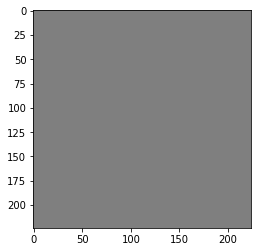

5, loss: -0.006934622768312693


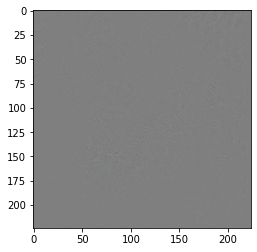

10, loss: -0.015795821323990822


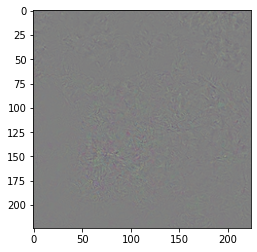

15, loss: -0.08077248185873032


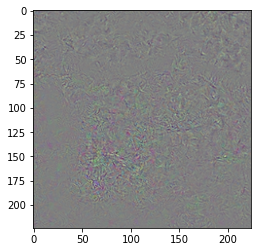

20, loss: -12.092191696166992


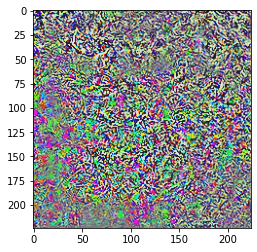

25, loss: -14.952634811401367


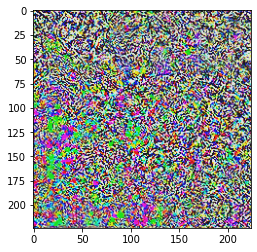

True class probability: 1.498790247467241e-08


In [15]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
optimizer = optim.SGD([delta], lr=1e-1)

for t in range(30):
    
    pred = model(norm(pig_tensor + delta))
    
    # the loss is negative, since we want to maximize it
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    
    if t % 5 == 0:
        print(f"{t}, loss: {loss.item()}")
        plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
        plt.show()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # clipping [-e, e]
    delta.data.clamp_(-epsilon, epsilon)
    
    
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

Now the ResNet50 is confident that the image is a **wombat** with a 99.99% probability

In [16]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.999985933303833


The adversarial example looks like the original pig

Text(0.5, 1.0, '"Wombat"')

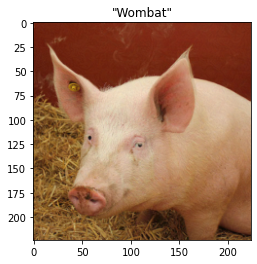

In [17]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
plt.title('"Wombat"')

And here is the $\delta$ added to image with a zoom of 50 in order to see properly

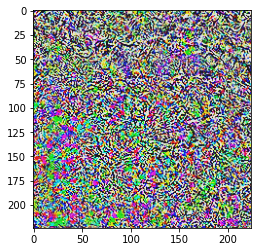

In [18]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

We should quantize the noise to the allowable level of the image (i.e., to within steps of 1/255). Thus, we can indeed craft images which are impossible for the human eye to distinguish the real and the adversarial.

## Targeted Attacks

We could make the image classified as other class we want. Instead of trying only to maximize the loss of the correct class, we also minimize the loss of the target class. Solving the following optimization problem

$$
\underset{\delta \in \Delta}{\text{maximize }} (\ell(h_\theta(x + \delta), y) - \ell(h_\theta(x + \delta), y_{target})) \equiv \underset{\delta \in \Delta}{\text{maximize }} \left( h_\theta(x + \delta)_{y_{target}} - h_\theta(x+\delta)_y \right)
$$

In [22]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(120):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.006046295166016
10 -0.3006401062011719
20 -7.818149566650391
30 -14.145238876342773
40 -19.913776397705078
50 -26.795330047607422
60 -28.212621688842773
70 -33.595985412597656
80 -35.872467041015625
90 -35.97798156738281
100 -38.53766632080078
110 -45.71413803100586


In [24]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9709441661834717


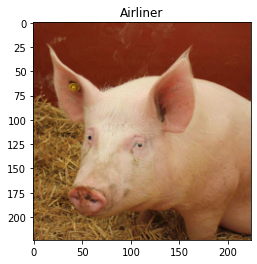

In [25]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
plt.title('Airliner')
plt.show()

> With adversarial attack you can make pigs fly

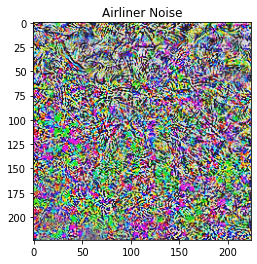

In [35]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
plt.title('Airliner Noise')
plt.show()